# Подготовительный этап

In [ ]:
import pandas as pd
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from scipy.spatial import distance_matrix
from scipy.optimize import minimize
import numpy as np
import sklearn

plt.style.use('ggplot')

Импортируем датасет MNIST (только тестовую его часть из 10 тыс. изображений)

In [ ]:
(_, _), (X, y) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
X.shape

(10000, 28, 28)

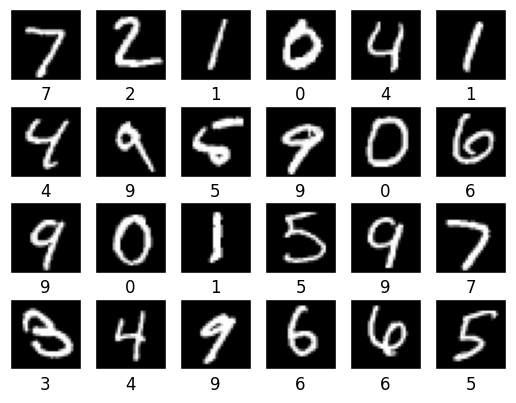

In [ ]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(X[i], cmap='gray')
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(y[i], color='black')

In [ ]:
X = X.reshape(len(X), -1)
X.shape

(10000, 784)

# MDS

## Библиотека

Рассмотрим еще один [метод снижения размерности](https://en.wikipedia.org/wiki/Multidimensional_scaling).

In [ ]:
link = 'https://courses.openedu.ru/assets/courseware/v1/6c89dd85d23926d43494d0e4dd968840/asset-v1:ITMOUniversity+INTROMLADVML+fall_2023_ITMO_mag+type@asset+block/94_16.csv'
data = pd.read_csv(link, header = None)
data.head()

,0,1,2,3,4,5,6,7,8,9
0,10.382991,-14.438544,-23.950798,-17.809813,2.480495,-15.743114,-9.112421,-27.390035,-11.955001,18.069910
1,18.987842,-13.071734,15.619164,-11.288528,-11.624820,14.845464,-4.924935,21.207876,-23.703025,4.440474
2,7.426000,-9.236580,-21.139348,6.732592,0.447684,-20.687020,-18.545136,7.758288,18.620790,-3.006755
3,10.718844,-10.240587,-20.604991,4.828083,-0.073568,-23.747055,-17.260869,7.074364,16.996747,-6.796469
4,10.662165,3.871777,12.384108,-1.921321,-1.990254,-5.469310,2.801321,-19.978717,23.414766,-2.654889


In [ ]:
mds = MDS(n_components=2, normalized_stress='auto')
data_mds = mds.fit_transform(data)
data_mds[:5]

array([[ 39.66882006,  -1.15123907],
       [ -8.92313011, -47.72054108],
       [  5.39281492,  33.84874195],
       [  6.90818658,  33.17169776],
       [-34.55176693,  15.20959421]])

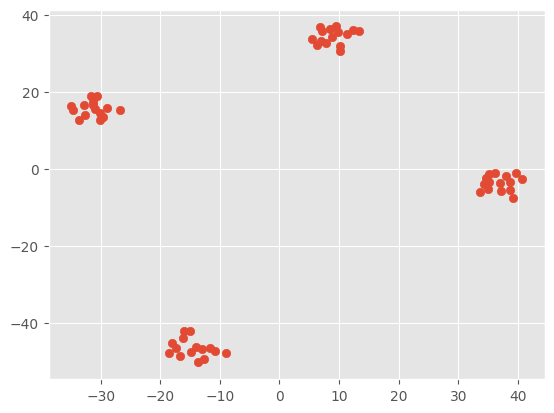

In [ ]:
plt.scatter(x=data_mds[:,0], y=data_mds[:,1])
plt.show()

## По шагам

In [ ]:
# @title Код для сохранения истории
# Модифицированный код из библиотеки, чтобы можно было проследить историю

def _smacof_single(
    dissimilarities,
    metric=True,
    n_components=2,
    init=None,
    max_iter=300,
    verbose=0,
    eps=1e-3,
    random_state=None,
    normalized_stress=False,
):

    dissimilarities = check_symmetric(dissimilarities, raise_exception=True)

    n_samples = dissimilarities.shape[0]
    random_state = check_random_state(random_state)

    sim_flat = ((1 - np.tri(n_samples)) * dissimilarities).ravel()
    sim_flat_w = sim_flat[sim_flat != 0]
    if init is None:
        # Randomly choose initial configuration
        X = random_state.uniform(size=n_samples * n_components)
        X = X.reshape((n_samples, n_components))
    else:
        # overrides the parameter p
        n_components = init.shape[1]
        if n_samples != init.shape[0]:
            raise ValueError(
                "init matrix should be of shape (%d, %d)" % (n_samples, n_components)
            )
        X = init

    old_stress = None
    ir = IsotonicRegression()
    history = []
    for it in range(max_iter):
        history.append(X)
        # Compute distance and monotonic regression
        dis = euclidean_distances(X)

        if metric:
            disparities = dissimilarities
        else:
            dis_flat = dis.ravel()
            # dissimilarities with 0 are considered as missing values
            dis_flat_w = dis_flat[sim_flat != 0]

            # Compute the disparities using a monotonic regression
            disparities_flat = ir.fit_transform(sim_flat_w, dis_flat_w)
            disparities = dis_flat.copy()
            disparities[sim_flat != 0] = disparities_flat
            disparities = disparities.reshape((n_samples, n_samples))
            disparities *= np.sqrt(
                (n_samples * (n_samples - 1) / 2) / (disparities**2).sum()
            )

        # Compute stress
        stress = ((dis.ravel() - disparities.ravel()) ** 2).sum() / 2
        if normalized_stress:
            stress = np.sqrt(stress / ((disparities.ravel() ** 2).sum() / 2))
        # Update X using the Guttman transform
        dis[dis == 0] = 1e-5
        ratio = disparities / dis
        B = -ratio
        B[np.arange(len(B)), np.arange(len(B))] += ratio.sum(axis=1)
        X = 1.0 / n_samples * np.dot(B, X)

        dis = np.sqrt((X**2).sum(axis=1)).sum()
        if verbose >= 2:
            print("it: %d, stress %s" % (it, stress))
        if old_stress is not None:
            if (old_stress - stress / dis) < eps:
                if verbose:
                    print("breaking at iteration %d with stress %s" % (it, stress))
                break
        old_stress = stress / dis

    return X, stress, it + 1, history

def smacof(
    dissimilarities,
    *,
    metric=True,
    n_components=2,
    init=None,
    n_init=8,
    n_jobs=None,
    max_iter=300,
    verbose=0,
    eps=1e-3,
    random_state=None,
    return_n_iter=False,
    normalized_stress="auto",
):

    dissimilarities = check_array(dissimilarities)
    random_state = check_random_state(random_state)

    if normalized_stress == "auto":
        normalized_stress = not metric

    if normalized_stress and metric:
        raise ValueError(
            "Normalized stress is not supported for metric MDS. Either set"
            " `normalized_stress=False` or use `metric=False`."
        )
    if hasattr(init, "__array__"):
        init = np.asarray(init).copy()
        if not n_init == 1:
            warnings.warn(
                "Explicit initial positions passed: "
                "performing only one init of the MDS instead of %d" % n_init
            )
            n_init = 1

    best_pos, best_stress = None, None


    if effective_n_jobs(n_jobs) == 1:
        for it in range(n_init):
            pos, stress, n_iter_, history = _smacof_single(
                dissimilarities,
                metric=metric,
                n_components=n_components,
                init=init,
                max_iter=max_iter,
                verbose=verbose,
                eps=eps,
                random_state=random_state,
                normalized_stress=normalized_stress,
            )
            if best_stress is None or stress < best_stress:
                best_stress = stress
                best_pos = pos.copy()
                best_iter = n_iter_
    else:
        seeds = random_state.randint(np.iinfo(np.int32).max, size=n_init)
        results = Parallel(n_jobs=n_jobs, verbose=max(verbose - 1, 0))(
            delayed(_smacof_single)(
                dissimilarities,
                metric=metric,
                n_components=n_components,
                init=init,
                max_iter=max_iter,
                verbose=verbose,
                eps=eps,
                random_state=seed,
                normalized_stress=normalized_stress,
            )
            for seed in seeds
        )
        positions, stress, n_iters = zip(*results)
        best = np.argmin(stress)
        best_stress = stress[best]
        best_pos = positions[best]
        best_iter = n_iters[best]

    if return_n_iter:
        return best_pos, best_stress, best_iter, history
    else:
        return best_pos, best_stress

from sklearn import *
import numpy as np
from joblib import effective_n_jobs

from sklearn.base import BaseEstimator, _fit_context
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import euclidean_distances
from sklearn.utils import check_array, check_random_state, check_symmetric
from sklearn.utils._param_validation import Interval, StrOptions, validate_params
from sklearn.utils.parallel import Parallel, delayed
# from sklearn.manifold._mds import _smacof_single


class MDS_modified(MDS):
  def fit_transform(self, X, y=None, init=None):
        """
        Fit the data from `X`, and returns the embedded coordinates.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features) or \
                (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.

        y : Ignored
            Not used, present for API consistency by convention.

        init : ndarray of shape (n_samples, n_components), default=None
            Starting configuration of the embedding to initialize the SMACOF
            algorithm. By default, the algorithm is initialized with a randomly
            chosen array.

        Returns
        -------
        X_new : ndarray of shape (n_samples, n_components)
            X transformed in the new space.
        """
        # X = validate_data(self, X)
        if X.shape[0] == X.shape[1] and self.dissimilarity != "precomputed":
            warnings.warn(
                "The MDS API has changed. ``fit`` now constructs an"
                " dissimilarity matrix from data. To use a custom "
                "dissimilarity matrix, set "
                "``dissimilarity='precomputed'``."
            )

        if self.dissimilarity == "precomputed":
            self.dissimilarity_matrix_ = X
        elif self.dissimilarity == "euclidean":
            self.dissimilarity_matrix_ = euclidean_distances(X)

        self.embedding_, self.stress_, self.n_iter_, history = smacof(
            self.dissimilarity_matrix_,
            metric=self.metric,
            n_components=self.n_components,
            init=init,
            n_init=self.n_init,
            n_jobs=self.n_jobs,
            max_iter=self.max_iter,
            verbose=self.verbose,
            eps=self.eps,
            random_state=self.random_state,
            return_n_iter=True,
            normalized_stress=self.normalized_stress,
        )

        return self.embedding_, history

In [ ]:
mds_1 = MDS_modified(n_components=2, normalized_stress='auto', n_jobs=1)
data_mds_1, history = mds_1.fit_transform(data)
data_mds_1[:5]

array([[-24.36817411, -31.3211168 ],
       [-33.17763118,  35.54277556],
       [ 24.11324807, -24.36097029],
       [ 22.68633898, -25.1856421 ],
       [ 32.69164906,  18.87786953]])

  0%|          | 0/55 [00:00<?, ?it/s]

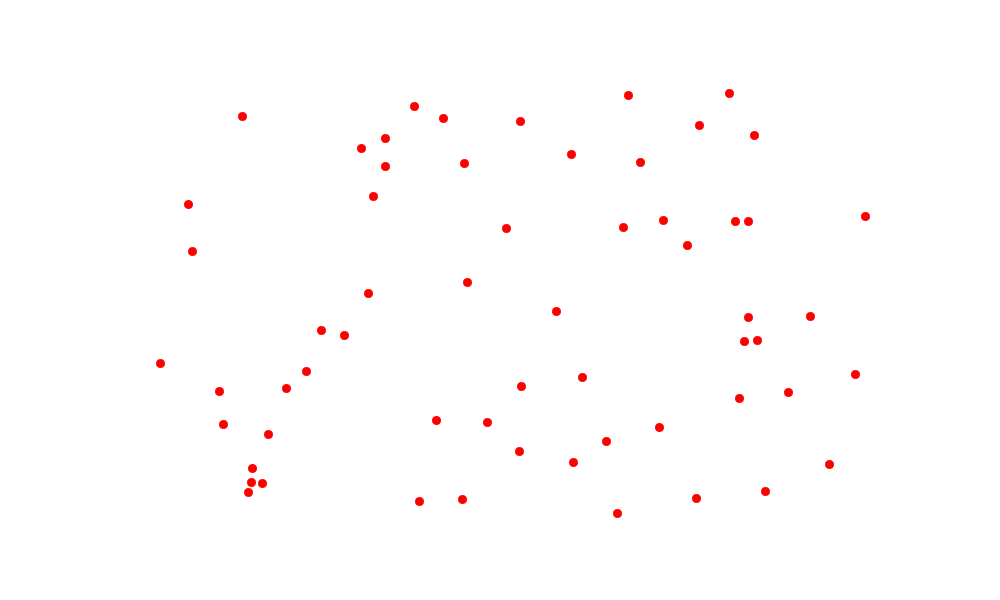

In [ ]:
# @title Создание анимации
import cv2
#from array2gif import write_gif
from tqdm.notebook import tqdm
from PIL import Image

history_imgs_numpy = []

for one_img in tqdm(history):
  plt.figure(figsize=(10,6))
  plt.scatter(x=one_img[:,0], y=one_img[:,1], c='blue')
  plt.axis("off")
  plt.savefig('tmp_img.png')
  plt.close()
  img_np = cv2.imread('tmp_img.png')
  history_imgs_numpy.append(img_np)


imgs = [Image.fromarray(img) for img in history_imgs_numpy]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array.gif", save_all=True, append_images=imgs[1:], duration=100, loop=0)
from IPython.display import Image
Image('/content/array.gif')

## **Задача**

Самостоятельно реализуйте класс MDS_manual. Для минимизации функции Stress рекомендуем использовать класс <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html"><code>minimize</code></a> из библиотеки <code>scipy</code>. Воспроизвести библиотечные результаты в таком случае не получится, но при построении объектов в новом пространстве признаков должны четко формироваться 4 группы.

In [ ]:
# @title Пример использования функции minimize

'''
Рассмотрим пример нахождения минимума функции z = (x-2)**2 + (y+1)**2.
Очевидно, что это параболоид с минимумом в точке (2,-1).
Обязательными параметрами minimize является неосредственно функция и начальная точка.
'''

# Зададим начальную точку (произвольно)
x0 = np.array([5,8])

# Определим функцию
def f(point):
  x,y = point
  return (x-2)**2 + (y+1)**2

# Минимизация
res = minimize(f, x0)

# Результат хранится в поле .x
print(res.x)


# Замечание: можно использовать и лямбда функцию
f = lambda point: (point[0]-2)**2 + (point[1]+1)**2
res = minimize(f, x0)
print(res.x)

[ 1.99999739 -0.99999916]
[ 1.99999739 -0.99999916]


In [ ]:
class MDS_manual:

    def __init__(self, n_components=2, metric=True, max_iter=1000, tol=1e-6):
        self.n_components = n_components
        self.metric = metric
        self.max_iter = max_iter
        self.tol = tol
        self.embedding_ = None
        self.stress_ = None

    def fit_transform(self, X):
        # Преобразуем в numpy array
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = np.array(X)

        n_samples = X.shape[0]

        # Шаг 1: Вычисляем матрицу попарных расстояний в исходном пространстве
        from scipy.spatial.distance import pdist, squareform
        self.D_original_ = pdist(X, metric='euclidean')
        D_square = squareform(self.D_original_)

        # Начальное приближение: PCA (классический MDS старт)
        # Центрируем матрицу Грама
        H = np.eye(n_samples) - np.ones((n_samples, n_samples)) / n_samples
        B = -0.5 * H @ (D_square ** 2) @ H
        eigenvals, eigenvecs = np.linalg.eigh(B)

        # Берём топ-k собственных векторов (по убыванию)
        idx = np.argsort(eigenvals)[::-1]
        eigenvals = eigenvals[idx]
        eigenvecs = eigenvecs[:, idx]

        # Убираем отрицательные собственные значения
        positive_eigs = np.maximum(eigenvals[:self.n_components], 0)
        L = np.sqrt(positive_eigs)
        V = eigenvecs[:, :self.n_components]
        X0 = V @ np.diag(L)

        # Шаг 2: Плоская начальная точка для оптимизации
        x0 = X0.flatten()

        # Целевая функция: стресс
        def stress_function(x):
            X_embedded = x.reshape(n_samples, self.n_components)
            distances = pdist(X_embedded, metric='euclidean')
            diff = self.D_original_ - distances
            stress = np.sum(diff ** 2) / (np.sum(self.D_original_ ** 2) + 1e-8)
            return stress

        # Оптимизация
        result = minimize(
            stress_function,
            x0,
            method='BFGS',
            tol=self.tol,
            options={'maxiter': self.max_iter, 'disp': False}
        )

        # Извлекаем результат
        self.embedding_ = result.x.reshape(n_samples, self.n_components)
        self.stress_ = result.fun

        return self.embedding_

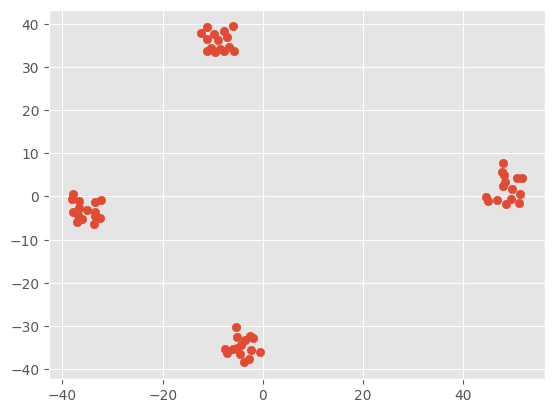

In [ ]:
mds_man = MDS_manual(n_components=2)
data_mds = mds_man.fit_transform(data)
plt.scatter(x=data_mds[:,0], y=data_mds[:,1])
plt.show()

# MDS на MNIST

Рассмотрим применение MDS на небольшом поднаборе MNIST

In [ ]:
n_samples = 1000

X_flat = X.reshape(X.shape[0],-1)[:n_samples]
X_MDS = mds.fit_transform(X_flat)
X_MDS[:3]

array([[ 1323.08351158,  1155.95106221],
       [  320.16559762, -2174.06239338],
       [  849.25854732,  -596.92286222]])

Визуализируем результат

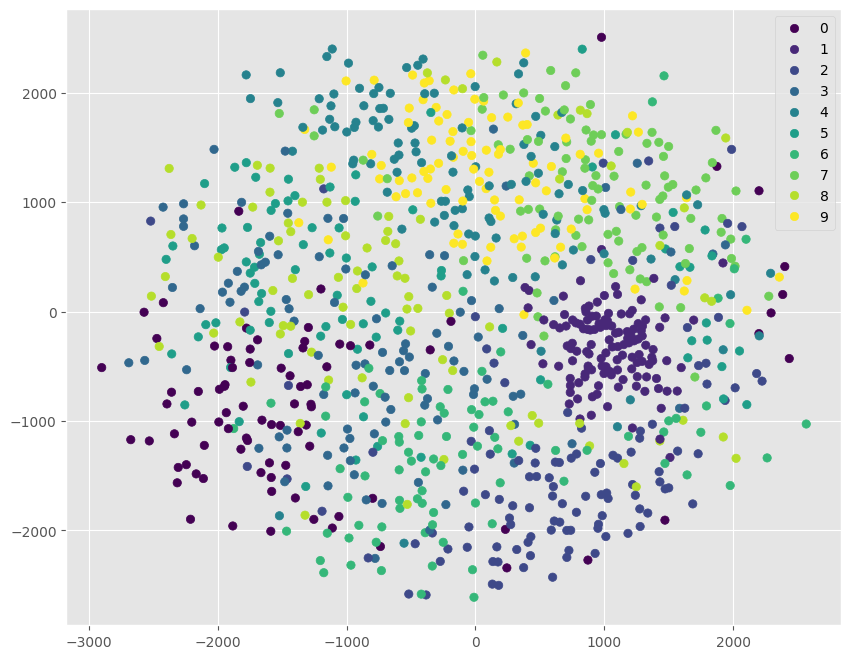

In [ ]:
plt.figure(figsize=(10,8))
sctr = plt.scatter(x=X_MDS[:,0], y=X_MDS[:,1], c=y[:n_samples])
plt.legend(*sctr.legend_elements())
plt.show()